In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc
import scipy
import matplotlib.pyplot as plt

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv('data.csv',names=['Id','y'])

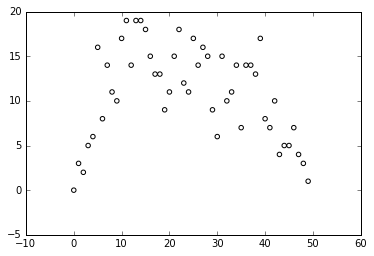

In [3]:
plt.scatter(data.Id,data.y,facecolor='none')
plt.show()

In [4]:
data.y.describe()

count    50.000000
mean     10.880000
std       5.231927
min       0.000000
25%       7.000000
50%      11.000000
75%      15.000000
max      19.000000
Name: y, dtype: float64

In [5]:
#隣接ベクトル
a1 = np.arange(50)
a2 = map(list,zip(a1-1,a1+1))
a2[0] = [1]
a2[-1] = [49]
A = np.array(a2)

In [6]:
#重みベクトル
W = np.array(map(lambda x: [x**(-1)*x],map(len,A)))

In [7]:
#n_jベクトル
Wplus = np.array([len(w) for w in W])

In [8]:
beta = pymc.Normal('beta',mu=0,tau=1.0e-4)
s = pymc.Uniform('s',lower=0,upper=1.0e+4)
tau = pymc.Lambda('tau',lambda s=s : s**(-2))

###Intrinstic CAR
@pymc.stochastic
def R(tau=tau,value=np.zeros(50)):
    mu = np.array([sum(W[i]*value[A[i]])/Wplus[i] for i in xrange(50)])
    taux = tau*Wplus
    return pymc.normal_like(value,mu,taux)
    
@pymc.deterministic
def M(beta=beta,R=R):
    return [np.exp(beta + R[i]) for i in xrange(50)]

obsvd = pymc.Poisson('obsvd',mu=M,value=data.y,observed=True)
model = pymc.Model([s,beta,obsvd])

In [9]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 19.8 sec

In [21]:
np.array([sum(W[i]*np.zeros(50)[A[i]])/Wplus[i] for i in xrange(50)])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Plotting beta


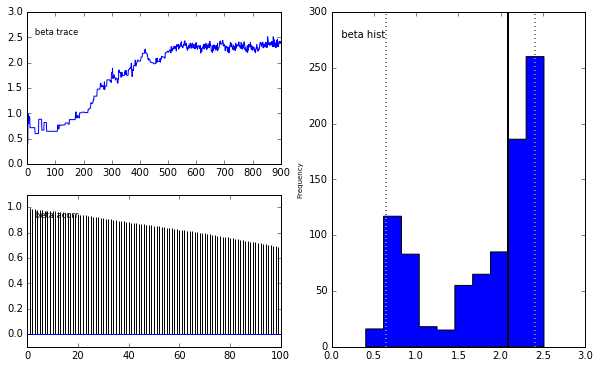

In [10]:
pymc.Matplot.plot(mcmc.trace('beta'),common_scale=False)

Plotting s


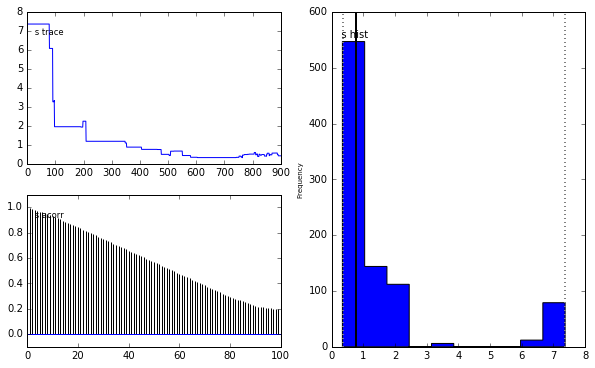

In [11]:
pymc.Matplot.plot(mcmc.trace("s"), common_scale=False)

In [12]:
b = np.mean(mcmc.trace('beta')[700:,None].flatten())
R = np.mean(mcmc.trace('R')[700:,None],axis=0).flatten()

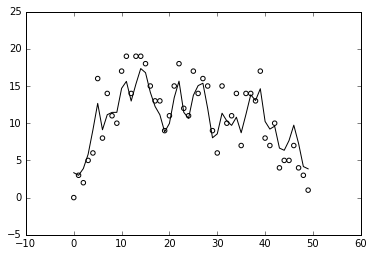

In [13]:
xx = np.arange(50)
yy = np.exp(b+R)
plt.plot(xx,yy,'k-')
plt.scatter(data.Id,data.y,facecolor='none')
plt.show()

In [14]:
b

2.3305686992385137